In [9]:
%config IPCompleter.greedy=True

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing, sklearn.datasets

In the previous chapter I introduces logistic regression and how it make prediction. I as well pointed out, that unlike Perceptron, logistic regression returns probability of datapoints belongs to specific class. However, I didn't mention the training algorithm for it. That would be content of this chapter.

I also demonstrated gradient descent algorithm in the second half of the previous chapter. There will be no surprise, that the gradient descent is the exact algorithm we are going to use in this chapter to train logistic regression.

# Logistic regression training

We now should have all the knowledge we need to train logistic regression. For reminder, prediction of the logistic regression is following:

$$
f(\pmb{x})=\frac{1}{1+e^{-\pmb{x}\pmb{w}^T}}
$$

In able to use gradient descent, we need some function, that the algorithm is going to optimize. Thats why I showed loss function. When we plug it in, we obtain the following formula.

$$
\mathcal{L}=\frac{1}{2} \sum_{i=0}^{n} \left( t_i - f(\pmb{x_i}) \right)^2 = \frac{1}{2} \sum_{i=0}^{n} \left( t_i - \frac{1}{1+e^{-\pmb{x}\pmb{w}^T}} \right)^2
$$

Now we want to update the weights, so we need to compute gradient of loss function in respect to weight (and we need to compute it for every weights). In this case, we can use the chain rule.

$$
\frac{\partial \mathcal{L}}{\partial w_i} = \frac{\partial \mathcal{L}}{\partial f(\pmb{x})} \cdot \frac{\partial f(\pmb{x})}{\partial \pmb{x}\pmb{w}^T} \cdot \frac{\partial \pmb{x}\pmb{w}^T}{\partial w_i}
$$

Then the gradient is easy to obtain (note that I mark $\sigma(x)$ as the sigmoid function, i.e. $\sigma(x)=\frac{1}{1+e^{-x}}$ and $y_i$ as the prediction of the model, i.e. $y_i = \sigma(\pmb{x}\pmb{w}^T)$.

$$\
\frac{\partial \mathcal{L}}{\partial w_i} = (t_i - y_i) \cdot -\sigma(\pmb{x}\pmb{w}^T)\left( 1 - \sigma(\pmb{x}\pmb{w}^T) \right) \cdot x_i
$$

Finally, let's put it all to the code.

I will use the same class as in the previous chapter (`Neuron`) and I will implement the fit method. Don't forget that the gradient descent algorithm needs learning, I will put it in the constructor.

In [81]:
class Neuron:
    def __init__(self, max_iters=100, random_state=None, learning_rate=0.001):
        self.max_iters = max_iters
        self.converged = False
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        self._learning_rate = learning_rate
        pass
    
    def _activation(self, vals):  # activation function
        return 1 / (1 + np.exp(-vals))
    
    def fit(self, X, y):
        # Initialize the weights
        self.converged = False
        self._weights = self._rand.uniform(-2, 2, X.shape[1])
        # Learning
        for iteration in range(self.max_iters):
            # shufle data randomly
            permutation = self._rand.permutation(len(X))       
            train_data = X[permutation]
            train_labels = y[permutation]
            # make gradient descent on each data point
            for datapoint, target in zip(train_data, train_labels):
                prediction = self.predict(datapoint)
                # compute gradient
                gradient = -(target - prediction) * (prediction * (1 - prediction)) * datapoint
                # update weights
                self._weights = self._weights - self._learning_rate * gradient
                
        return self
    
    def predict(self, X):
            return self._activation(X @ self._weights)
    
    def __call__(self, X):
        return self.predict(X)

The algorithm makes `self.max_iters` iterations and in each iteration, it randomly shuffle the data and perform gradient descent for each data point. That mean the algorithm will make `self.max_iters * len(X)` gradient descent executions during training. Let's see how the algorithm behave on some dataset.

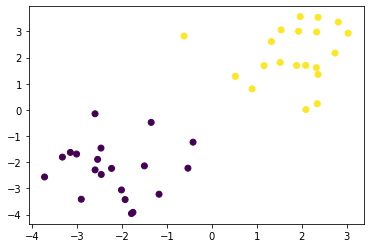

In [58]:
data, classes = sklearn.datasets.make_blobs(
    n_samples=40,
    n_features=2,
    centers=[[-2, -2], [2, 2]],
    random_state=42,
)
plt.scatter(data[:,0], data[:,1], c=classes)
plt.show()

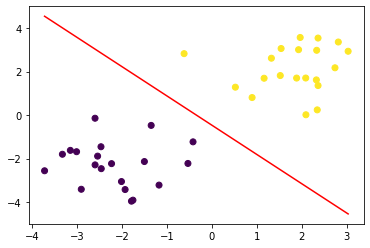

In [83]:
# Train the logistic regression
train_data = np.hstack([data, np.ones((data.shape[0],1))])  # add bias
n = Neuron(random_state=41, max_iters=500, learning_rate=0.01)
n.fit(train_data, classes)

# Visualize results
plt.scatter(data[:,0], data[:,1], c=classes)
slope = - n._weights[0] / n._weights[1]
bias = n._weights[2] / n._weights[1]
plt.plot(
    [data.min(axis=0)[0], data.max(0)[0]], 
    [slope * data.min(axis=0)[0] - bias, slope * data.max(axis=0)[0] - bias],
    c='r')
plt.show()